# Programming for Data Science and Artificial Intelligence

## Unsupervised Learning - Clustering - GMM

### Readings:
- [VANDER] Ch5
- [HASTIE] Ch14.3
- https://scikit-learn.org/stable/modules/clustering.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gaussian Mixture Models

Instead of simply assuming a spherical (circular) shape, we can generalize the Expectation-Maximization algorithm to "weighted sum" of gaussian distribution, we can create a more powerful model - essentially **Gaussian Mixture models**

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.  Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Mixture models can be used to describe a describution $p(x)$ by a convex combination of $K$ simple (base) distributions:

$$p(x) = \sum\limits_{k=1}^K \pi_k p_k(x)$$

$$ 0 \leq \pi_k \leq 1 $$

$$ \sum\limits_{k=1}^K \pi_k = 1 $$

where the components $p_k$ are members of a family of basic distributions, e.g., Gaussians, Bernoullis, or Gammas, and the $\pi_k$ are *mixture weights*.  Using these weights allow us to describe datasets with multiple "clusters".   

Here we shall focus on **Gaussian** mixture models (GMMs), where the basic distributions are Gaussians.  For a given dataset, we aim to maximize the likelihood of the model parammeters to train the GMM.

A *Gaussian mixture model* is a density model where we combine a finite number of $K$ Gaussian distributions $$ \mathcal{N} (x | \mu_k, \Sigma_k)$$ so that

$$p(x | \theta) = \sum\limits_{k=1}^K \pi_k \mathcal{N} (x | \mu_k, \Sigma_k)$$

$$0 \leq \pi_k \leq 1$$

$$\sum\limits_{k=1}^K \pi_k=1$$

where we define $\theta$ as

$$\theta := \{\mu_k, \Sigma_k, \pi_k: k = 1, \cdots, K\}$$

and $\mathcal{N}$ as the multivariate Gaussian distribution, computed using:

$$\mathcal{N} (x | \mu_k, \Sigma_k)= \frac{1}{(2\pi)^\frac{n}{2}\lvert{\Sigma_k}\rvert^\frac{1}{2}}\exp(-\frac{1}{2}(x -\mu_k)^T\Sigma_{k}^{-1}(x - \mu_k))$$

as the collection of all parameters of the model.  This convex combination of Gaussian distribution gives us significantly more flexibility for modeling complex densities than a simple Gaussian distribution.

**Learning**

Assume $X = \{x^{(i)}, \cdots, x^{(m)}\}$ are drawn form an unkown distribution $p(x)$.  Our objective is to find a good approximation of this unknown distribution by means of a GMM with $K$ mixture components.  We exploit our i.i.d (independently and identically distributed) assumption, which leads to the log-likelihood as

$$\log p(X | \theta) = \sum\limits_{i=1}^m \log p(x^{(i)} | \theta) = \sum\limits_{i=1}^m \log \sum\limits_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

Our objective function is to find $\theta$ that maximize the log-likehood $\mathcal{L}$

$$
\max_\theta \sum\limits_{i=1}^m \log \sum\limits_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

Our "normal" procedure would be to comute the gradient $\frac{d\mathcal{L}}{d\theta}$ of the log-likelihood with respect to the model parameters $\theta$, set it to 0, and solve for $\theta$, however, if you try this yourself at home, you will find that it is not possible to find the closed form.

One way we can do turns out to be the EM algorithm, where the key idea is to update one model parameter at a time, while keeping the others fixed.

Before we find the partial derivatives, let us introduce a quantity that will play a central role in this algorithm: **responsibilities**.

We define the quantity

$$ r^{(i)}_{k} = \frac{\pi_k\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)}$$

as the *responsibility* of the $k$th mixture component for the $i$th data point.  

$r^{(i)}_{k}$ basically gives us $$ \frac{\text{Probability of $x^{(i)}$ belonging to cluster k}}{\text{Probability of $x^{(i)}$ over all clusters}} $$

The responsibility $r^{(i)}_{k}$ of the $k$th mixture component for data point $x^{(i)}$ is proportional to the likelihood of the mixture component given the data point.

$$p(x^{(i)} | \pi_k, \mu_k, \Sigma_k) = \pi_k\mathcal{N}(x^{(i)}|\mu_k, \Sigma_k)$$

Therefore, mixture components have a high responsibility for a data point when the data point could be a **plausible sample** from that mixture component.  Note that 

$$r^{(i)} = r^{(i)}_1, r^{(i)}_2, \cdots, r^{(i)}_k \in \mathbb{R}^k$$

is a normalized probability vector, i.e., for each sample $i$

$$\sum\limits_{j=1}^{k}r^{(i)}_j = 1$$

$$ r^{(i)}_j \geq 0 $$

Thus this probability vector distributes probability mass among the $K$ mixture components, and we can think of $r^{(ik)}$ as probability that $x^{(i)}$ has been generated by the $k$th mixture component.

By summing all the total responsibility of the $k$th mixture component along all samples, we get $N_k$.

$$N_k = \sum\limits_{i=1}^{m}r^{(i)}_k$$

Note that this value does not necessarily equal to 1.

**Updating the mean**

The update of the mean parameters $\mu_k, k=1,\cdots,K$ of the GMM is given by:

$$ \mu_k^{new} = \frac{\sum\limits_{i=1}^{m}r^{(i)}_{k}x^{(i)}}{\sum\limits_{i=1}^{m}r^{(i)}_{k}}$$

To prove this:

Any local optimum of a function exhibits the property that its gradient with respect to the parameters must vanish, i.e., setting its partial derivative to zero.

We take a partial derivative of our objective function with respect to the mean parameters $\mu_k, k=1, \cdots, K$.  To simplify things, let's perform partial derivative without the log first and only consider one sample.

$$
	\frac{\partial p(x^{(i)} | \theta)}{\partial \mu_k} = \sum\limits_{j=1}^K \pi_j \frac{\partial \mathcal{N}(x^{(i)} | \mu_j, \Sigma_j)}{\partial \mu_k} = \pi_k \frac{\partial \mathcal{N}(x^{(i)} | \mu_k, \Sigma_k)}{\partial \mu_k} = \pi_k(x^{(i)} - \mu_k)^T \Sigma_k^{-1}\mathcal{N}(x^{(i)} | \mu_k, \Sigma_k)
$$

Now, taking all samples and log, since we know the partial derivative of $\log$ something is $\frac{1}{x}$, thus

$$
\frac{\partial \mathcal{L}}{\partial \mu_k} =\sum\limits_{i=1}^{m} \frac{\partial \log p(x^{(i)} | \theta)}{\partial \mu_k} = \sum\limits_{i=1}^{m} \frac{1}{p(x^{(i)} | \theta)} \frac{\partial p(x^{(i)} | \theta) }{\partial \mu_k} = \sum\limits_{i=1}^{m}(x^{(i)} - \mu_k)^T \Sigma_k^{-1}\frac{\pi_k\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)}
$$

To simplify, we can substitute $r^{(i)}_{k}$ into the equation, thus

$$= \sum\limits_{i=1}^{m} r^{(i)}_{k}(x^{(i)} - \mu_k)^T\Sigma_k^{-1}$$

We can now solve for $\mu_k$ so that $\frac{\partial \mathcal{L}}{\partial \mu_k} = 0$ and obtain

$$\sum\limits_{i=1}^{m} r^{(i)}_{k}(x^{(i)} - \mu_k)^T\Sigma_k^{-1} = 0$$

Multiply both sides by $\Sigma$ will cancel out the inverse $\Sigma$, and move $\mu_k$ to another side

$$\sum\limits_{i=1}^{m} r^{(i)}_{k}x^{(i)}  = \sum\limits_{i=1}^{m} r^{(i)}_{k}\mu_k$$

$$\frac{\sum\limits_{i=1}^{m} r^{(i)}_{k}x^{(i)} }{\sum\limits_{i=1}^{m} r^{(i)}_{k}}  = \mu_k$$

We can further substitute $N_k$ so that

$$
\frac{1}{N_k}\sum\limits_{i=1}^{m} r^{(i)}_{k}x^{(i)} = \mu_k
$$

Here we can interpret that $\mu_k$ is pulled toward a data point $x^{(i)}$ with strength given by $r^{(i)}_{k}$.  The means are pulled stronger toward data points for which the corresponding mixture component has a high responsibility, i.e., a high likelihood.

**Updating the covariances**

The update of the covariance parameters $\Sigma_k, k=1,\cdots,K$ of the GMM is given by:

$$ \Sigma_k^{new} = \frac{1}{N_k} \sum\limits_{i=1}^{m}r^{(i)}_{k}(x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^T $$

To prove this:

We take a partial derivative of our objective function with respect to the Sigma parameters $\Sigma_k, k=1, \cdots, K$.  Similarly, to simplify things, let's perform partial derivative without the log first and only consider one sample.

$$
	\frac{\partial p(x^{(i)} | \theta)}{\partial \Sigma_k} = \frac{\partial}{\partial \Sigma_k} \big(\pi_k(2\pi)^{-\frac{D}{2}} \det(\Sigma_k)^{\frac{1}{2}}exp\big(-\frac{1}{2}(x^{(i)} - \mu_k)^T\Sigma^{-1}_k(x^{(i)} - \mu_k)\big)\big)
$$

Using derivative multiplication rule, we got

$$
= \pi_k(2\pi)^{-\frac{D}{2}}\big[\frac{\partial}{\partial \Sigma_k}\det(\Sigma_k)^{-\frac{1}{2}}exp\big(-\frac{1}{2}(x^{(i)} - \mu_k)^T\Sigma^{-1}_k(x^{(i)} - \mu_k)) + \det(\Sigma_k)^{-\frac{1}{2}}\frac{\partial}{\partial \Sigma_k}exp\big(-\frac{1}{2}(x^{(i)} - \mu_k)^T\Sigma^{-1}_k(x^{(i)} - \mu_k)\big]
$$

Using this following rule

$$
\frac{\partial}{\partial X}\det(f(x)) = \det(f(x))tr\big(f(x)^{-1}\frac{\partial f(x)}{\partial x}\big)
$$

We get that

$$
\frac{\partial}{\partial \Sigma_k}\det(\Sigma_k)^{-\frac{1}{2}} = -\frac{1}{2}\det(\Sigma_k)^{-\frac{1}{2}}\Sigma_k^{-1}
$$

Using this following rule

$$
\frac{\partial a^TXb}{\partial X} = ab^T
$$

We get that

$$
\frac{\partial}{\partial \Sigma_k}(x^{(i)} - \mu_k)^T\Sigma^{-1}_k(x^{(i)} - \mu_k) = -\Sigma_k^{-1}(x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^T\Sigma_k^{-1}
$$

Putting them together, we got:

$$
\frac{\partial p(x^{(i)} | \theta)}{\partial \Sigma_k} = \pi_k\mathcal{N}(x^{(i)} | \mu_k, \Sigma_k) * \big[-\frac{1}{2}(\Sigma_k^{-1}-\Sigma_k^{-1}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T\Sigma_k^{-1}\big]
$$

Now consider all samples and log as well, the partial derivative of the log-likelihood with respect to $\Sigma_k$ is given by

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \Sigma_k} &=  \sum\limits_{i=1}^{m}\frac{\partial \log p(x^{(i)} | \theta)}{\partial \Sigma_k}\\
&=\sum\limits_{i=1}^{m}\frac{1}{(p(x^{(i)} | \theta)}\frac{\partial p(x^{(i)} | \theta)}{\partial \Sigma_k}\\
&=\sum\limits_{i=1}^{m}\frac{\pi_k\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)} * \big[-\frac{1}{2}(\Sigma_k^{-1}-\Sigma_k^{-1}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T\Sigma_k^{-1})\big]
\end{aligned}
$$

Substituting $r^{(i)}_{k}$, we got

$$
= -\frac{1}{2}\sum\limits_{i=1}^{m}r^{(i)}_{k}(\Sigma_k^{-1}-\Sigma_k^{-1}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T\Sigma_k^{-1})\\
= -\frac{1}{2}\Sigma_k^{-1}\sum\limits_{i=1}^{m}r^{(i)}_{k} + \frac{1}{2}\Sigma_k^{-1}\big(\sum\limits_{i=1}^{m}r^{(i)}_{k}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T\big)\Sigma_k^{-1}
$$

Setting this to zero, we obtain:

$$
N_k\Sigma_k^{-1} = \Sigma_k^{-1}\big(\sum\limits_{i=1}^m r^{(i)}_{k}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T\big)\Sigma_k^{-1}
$$

By solving for $\Sigma_k$ we got

$$
\Sigma_k = \frac{1}{N_k}\sum\limits_{i=1}^{m}r^{(i)}_{k}(x^{(i)}-\mu_k)(x^{(i)} - \mu_k)^T
$$

**Updating the pi - weight of mixture components**

The update of the mixture weights $\pi_k, k=1,\cdots,K$ of the GMM is given by:

$$ \pi_k^{new} = \frac{N_k}{m}$$

To prove this:

To find the partial derivative, we account for the equality constraint 

$$\sum\limits_{k=1}^K \pi_k=1$$

The Lagrangian $\mathscr{L}$ is

$$
\begin{aligned}
\mathscr{L} &= \mathcal{L} + \beta\big(\sum\limits_{k=1}^K \pi_k-1\big)\\
&= \sum\limits_{i=1}^m \log \sum\limits_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k) + \beta\big(\sum\limits_{k=1}^K \pi_k-1\big)
\end{aligned}
$$

Taking the partial derivative with respect to $\pi_k$ as

$$
\begin{aligned}
\frac{\partial \mathscr{L}}{\partial \pi_k} &= \sum\limits_{i=1}^m
\frac{\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)} + \beta \\
&= \frac{1}{\pi_k}\sum\limits_{i=1}^m\frac{\pi_k\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)} + \beta\\
&= \frac{N_k}{\pi_k} + \beta
\end{aligned}
$$

Taking the partial derivative with respect to $\beta$ is

$$
\frac{\partial \mathscr{L}}{\partial \beta} = \sum\limits_{i=1}^{K} \pi_k - 1
$$

Setting both partial derivatives to zero yield

$$
\pi_k = -\frac{N_k}{\beta}
$$

$$
1 = \sum\limits_{i=1}^K\pi_k
$$

Using the top formula to solve for the bottom formula:

$$    
- \sum\limits_{i=1}^{m}\frac{N_k}{\beta} = 1\\
= -\frac{m}{\beta} = 1\\
= \beta = -m
$$

Substitute $-m$ for $\beta$ yield

$$
\pi_k = \frac{N_k}{m}
$$

**Algorithm**

Thus, we can summarize the whole algorithm into the following steps:

1. Define $k$ number of clusters $c$
2. For each cluster k, randomly initialize parameters mean $\mu_k$, covariance $\Sigma_k$, and fraction per class $\pi_k$ 

3. *E-step:*  Evaluate responsibilities $r^{(i)}_{k}$ for every data point $x^{(i)}$ using 

$$ r^{(i)}_{k} = \frac{\pi_k\mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_{k})}{\Sigma_{j=1}^{K} \pi_j\mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)}$$

4. *M-step:*  Restimate parameters $\pi_k, \mu_k, \Sigma_k$ using the current responsibilites $r^{(i)}_{k}$ from the E step.

$$ \mu_k = \frac{1}{N_k} \sum\limits_{i=1}^{m}r^{(i)}_{k}x^{(i)}$$

$$ \Sigma{_k} = \frac{1}{N_k} \sum\limits_{i=1}^{m}r^{(i)}_{k}(x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^T$$

$$ \pi_k = \frac{N_k}{m}$$

**Coding considerations**

1.  To ease our programming efforts, we can use <code>scipy.stats.multivariate_normal</code> for generating gaussian distribution, and using its <code>.pdf()</code> function to compute the values we want of $N(x_i \mid \mu_k, \Sigma_k)$

2. Shape of $r$ which keeps probability of $x^{(i)}$ belonging to $k$th cluster is $(m * k)$, where m is <code>X.shape[0]</code> and $k$ is number of clusters we want.  

3. Shape of $\Sigma$ or covariance of each cluster is simply $(n * n)$ where n is number of features or <code>X.shape[1]</code>. If we define 3 clusters, then we will have [$\Sigma_1$, $\Sigma_2$, $\Sigma_3$], each with shape $(n * n)$, thus whole thing is shape $ (k * n * n) $

4. Shape of $\pi$ is simply $(k, )$
    
5. Shape of $\mu$ is $(n, k)$, defining mean for each feature for $k$th cluster

6. What to initialize can be tricky.  For $r$ and $\pi$, you can fill with $1/k$.  As for $\mu$, it is easiest to simply pick random points from the samples as initial means.  Last, for covariance ($\Sigma$), we can simply use the covariance of the $X$ as initialization (i.e., <code>np.cov(X.T)</code>)


### Scratch

Text(0.5, 1.0, 'Final')

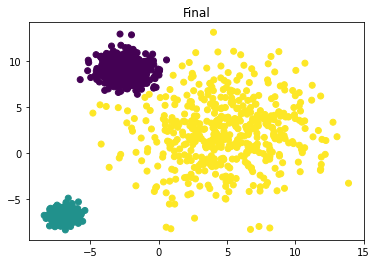

In [15]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import math

X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 3.5, 0.5], random_state=42)

#define basic params
m, n = X.shape
K = 3
max_iter = 20

#==initialization==

#responsibliity
r = np.full(shape=(m, K), fill_value=1/K)

#pi
pi = np.full((K, ), fill_value=1/K) #simply use 1/k for pi

#mean
random_row = np.random.randint(low=0, high=m, size=K)
mean = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)

#covariance
cov = np.array([np.cov(X.T) for _ in range (K)])

for iteration in range(max_iter):
    
    #===E-Step=====
    #Update r_ik of each sample
    for i in range(m):
        for k in range(K):
            xi_pdf = multivariate_normal.pdf(X[i], mean=mean[:, k], cov=cov[k])
            r[i, k] = pi[k] * xi_pdf
        r[i] /= np.sum(r[i])
    
    #===M-Step====
    # Find NK first for latter use
    NK = np.sum(r, axis=0)
    assert NK.shape == (K, )
    
    #PI
    pi = NK / m
    assert pi.shape == (K, )
    
    #mean
    mean =  ( X.T @ r ) / NK
    assert mean.shape == (n, K)
    
    #covariance (also called Sigma)
    cov = np.zeros((K, n, n))
    for k in range(K):
        for i in range(m):
            X_mean = (X[i]-mean[:, k]).reshape(-1, 1)
            cov[k] += r[i, k] * (X_mean @ X_mean.T)
        cov[k] /= NK[k]
    assert cov.shape == (K, n, n)
        

#get preds
yhat = np.argmax(r, axis=1)

#plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=yhat)
plt.title("Final")

### Sklearn

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.  That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

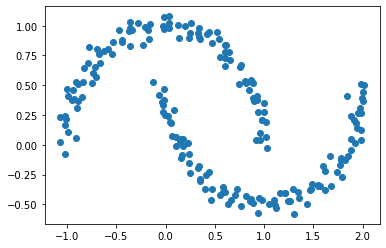

In [16]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

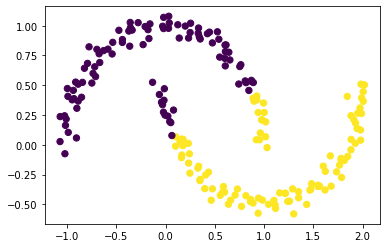

In [17]:
from sklearn.mixture import GaussianMixture as GMM
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
pred = gmm2.fit(Xmoon).predict(Xmoon)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c=pred, s=40, cmap='viridis')

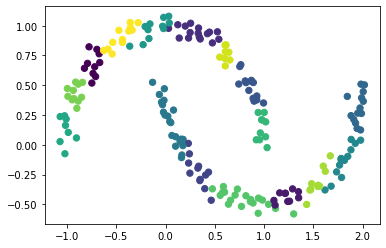

In [18]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
pred = gmm16.fit(Xmoon).predict(Xmoon)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c=pred, s=40, cmap='viridis')

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

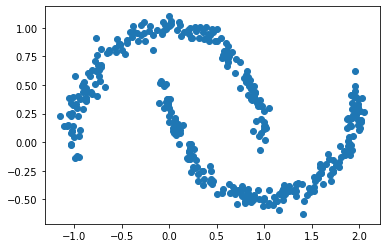

In [19]:
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

The above data is a "generated" data - not real data.  So by understanding the distribution, it is useful to generate the data

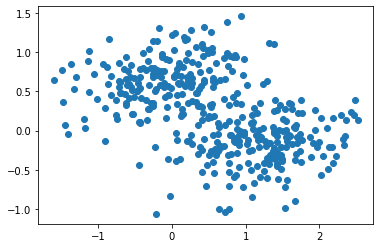

In [20]:
#Let's also take a look on gmm2.sample
Xnew, _ = gmm2.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

#### How many components for understanding distribution?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.

Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

$$ AIC = 2k - 2ln(L) $$

$$ BIC = kln(n) - 2ln(L) $$

where k is the number of features and L is maximum likelihood.  Basically,  number of features will increase AIC, while L will decrease AIC.  We want to good balance between model complexity and goodness of fit, thus lower the AIC, the better.

Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute AIc, and so it is very easy to operate on this approach.

Let's look at the AIC as a function as the number of GMM components for our moon dataset:

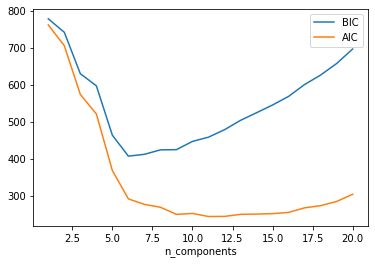

In [21]:
n_components = np.arange(1, 21)
models = [GMM(n, random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

#### Example: GMM for Generating New Data

Here, since GMM is kind of model that tries to understand the data probability distribution.  GMM can be used to generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

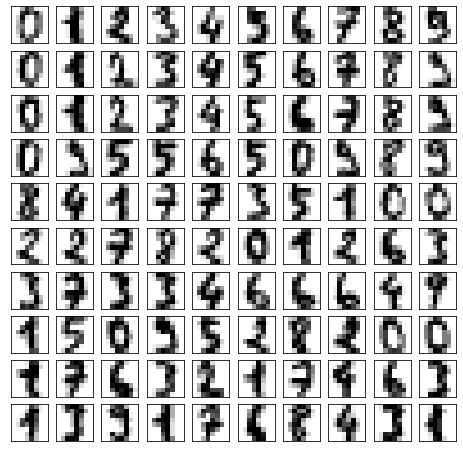

In [24]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [25]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape  #41 dimensions

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

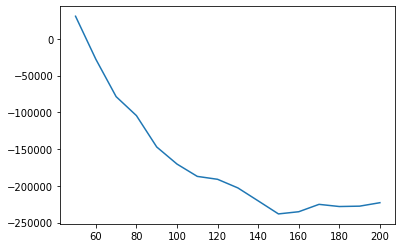

In [26]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [27]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [28]:
X, y = gmm.sample(100)
X.shape

(100, 41)

*Finally*, we can use the inverse transform of the PCA object to construct the new digits:

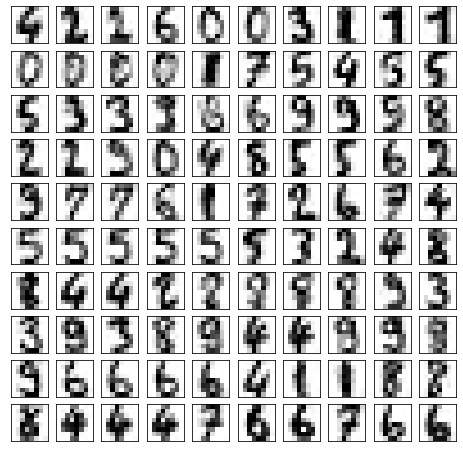

In [29]:
digits_new = pca.inverse_transform(X)
plot_digits(digits_new)

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits is perhaps the basic idea behind **"Generative Adversarial Network"**

### ===Task===

Your work: Let's modify the above scratch code:
- Modify so it performs early stopping when the log likelihood does not improve anymore.
- Perform plotting every 5 iterations on the resulting clusters.